# Package Definitions

In [1]:
## Package for Preferential Attachment Model with Delay
## Version June 28, 2022

## This model generates graphs from Preferential Attachment Model with Delay 
## where at any time t, m edges are created based on graph at time (t - delay_t)_+ 
## with edge probability proportional to (degree + delta)
## For the no delay model, the exponent for the Asymptotic Degree distribution should be $ 3 + \delta/m $

## Load packages as needed
import numpy as np
import networkx as nx
from networkx.utils import py_random_state
import matplotlib.pyplot as plt
import random, time, math
import matplotlib.ticker as ticker
import csv
import os
from tabulate import tabulate

In [2]:
## Auxiliary functions for plot axis labels
def pow10(x, pos):
    """The two arguments are the value and tick position."""
    return '$10^{'+'{:1.1f}'.format(x)+'}$'


In [3]:
## Taken from np random graph generator 
## fastest with integer computations
## Return m unique elements from seq.
## Note: rng is a random.Random or numpy.random.RandomState instance.

def _random_subset(seq, m, rng):
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [4]:
## This can take cumulative weights
## two times slower then _random_subset
## with floating point computations
## Return m unique elements from seq.
## Note: rng is a random.Random or numpy.random.RandomState instance."""

def _random_subset_pr(seq, m, cweight, rng):
    targets = []
    while len(targets) < m:
        x = rng.choices(seq, cum_weights=cweight, k=1)
        targets.extend(x)
    return targets

In [5]:
## Functions to generate one sample from Preferential Attachment model with Delay

## PA(N, m, Delta) - No delay, integer Delta
@py_random_state(5)
def pa(n, m, delta=0, dela=1, G0=None, seed=None):
    # DELTA must be a non-negative integer
    if G0==None:
        G = nx.star_graph(m)
    else:
        G = G0.copy()
    repeated_nodes = [i for (i, d) in G.degree() for _ in range(d + delta) ]
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * (m+delta))
        source += 1
    return G

## PAD(N,m,Delta=0,Delay=1) - With Delay, integer Delta
@py_random_state(5)
def pad(n, m, delta=0, dela=1, G0=None, seed=None):
    """Return random graph using preferential attachment model with delay.
    Delta must be an integer for this program"""
    # Process the delay to get connection nodes
    if type(dela)==int: 
        delay = np.maximum(range(n) - dela, 0)
    else:
        delay = np.maximum(range(n) - dela.astype(int), 0)
    if G0==None:
        G = nx.star_graph(m)
    else:
        G = G0.copy()
    repeated_nodes = [i for (i, d) in G.degree() for _ in range(d + delta) ]
    pos = [len(repeated_nodes) for _ in G.nodes()]
    targets = _random_subset(repeated_nodes, m, seed)
    source = len(G)
    while source<n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip(targets,[source] * m))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * (m + delta))
        pos.extend([pos[-1]+2*m+delta])
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        ds = delay[source]
        posds = pos[ds]
        if ds==source-1:
            targets = _random_subset(repeated_nodes, m, seed)
        else:
            targets = _random_subset(repeated_nodes[:posds], m, seed)
        source += 1
    return G

## PADGEN(N,m,Delta=0,Delay=1) - With Delay, real Delta
@py_random_state(5)
def padgen(n, m, delta=0, dela=1, G0=None, seed=None):
    """Return random graph using preferential attachment model with delay.
    Delta can be any real number > -1 for this program"""
    # Process the delay to get connection nodes
    if type(dela)==int: 
        delay = np.maximum([i-dela for i in range(n)], 0)
    else:
        delay = np.maximum(range(n) - dela.astype(int), 0)
    if G0==None:
        G = nx.star_graph(m)
    else:
        G = G0.copy()
    repeated_nodes = [k for (k, d) in G.degree()]
    cweight_nodes = list(np.cumsum([d for (k, d) in G.degree()]))
    pos = [len(G) for _ in G.nodes()]
    # Start adding the other n-m0 nodes. The first node is m.
    targets = _random_subset_pr(repeated_nodes, m, cweight_nodes, seed)
    source = len(G)
    while source<n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip(targets,[source]*m))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend([source])
        cweight_nodes.extend([cweight_nodes[-1]+m+delta])
        repeated_nodes.extend(targets)
        cweight_nodes.extend([cweight_nodes[-1]+k+1 for k in range(m)])
        # And the new node "source" has m edges to add to the list.
        pos.extend([pos[-1]+m+1])
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        ds = delay[source]
        posds = pos[ds]
        if ds==source-1:
            targets = _random_subset_pr(repeated_nodes, m, cweight_nodes, seed)
        else:
            targets = _random_subset_pr(repeated_nodes[:posds], m, cweight_nodes[:posds], seed)
        source += 1
    return G

Simulate from No Delay and with Delay Model. 

For delay distribution, we consider Pareto type distributions with exponent given by $A$, so that the upper tail probability of the delay random variable $\delta$ at  $k$ is given by $k^{-A}$ and the mean of $\delta^l$ is finite if and only if $l<A$. 

We take for $A\geq 1$, delay=int($A$),
for $0<A<1$, delay $\sim$ Geometric$(A)$, and
for $A<0$,
delay = ceil($U^{-1/A}$) where $U$ is Uniform(0,1) random variable, so that $P(delay>x)=P(U<x^{-A})=x^{-A}$.

In [6]:
def run( N=10000, M=1, DELTA=0, A=1, SAMPLE_SIZE=1, G0=None):
    '''Run the Simulation'''

    ## Delay distribution setup
    if A==0 or A>=1:
        A = np.maximum(int(A),1)
        DELAY_GEN = lambda x: A*np.ones(x)
    elif A>0 and A<1:
        DELAY_GEN = lambda x: np.random.geometric(p = A, size = x)
    else:
        DELAY_GEN = lambda x: np.random.random(size=x)**(1/A)
    
    ## PA+DELAY model generator function setup
    if not isinstance(DELTA, int):
        func = padgen
    elif A==1: ## No Delay
        func = pa
    else: ## Delta integer but with Delay
        func = pad
    
    G_f = []
    ## Run the simulation
    start = time.time()
    for _ in range(SAMPLE_SIZE):
        DELAY = DELAY_GEN(N)
        G = func(N, M, DELTA, DELAY, G0)
        G_f.append(G)
    end = time.time()
    print('Time taken = %.2f Seconds'%(end - start))
    return G_f


# Default Parameter Values

In [7]:
## Default Parameter Values

N = 10000      ## Size of the Graph

M = 1           ## Number of outgoing connections per node

DELTA = 0       ## Additive parameter in Preferential Attachment model

A = 1           ## A=0,1 no delay, 
                ## 0<A<1 Geometric(A) delay,
                ## A>1 constant delay, 
                ## A<0 random delay with $U^{1/A}$

G0 = None       ## Initial graph, None is equivalent to nx.star_graph
                ## Other options are complete_graph, empty_graph
                ## For M=1, Delta=0 graphs with no edges will create an error

SAMPLE_SIZE = 1 ## Number of samples

# Simulations

In [8]:
def execute(N, M, DELTA, A, SAMPLE_SIZE):
    filename =  "newtest" + str(A) + ".csv"
    header = [N, M, DELTA, -A, SAMPLE_SIZE]
    G_f = run(N, M, DELTA, A, SAMPLE_SIZE)

    with open(filename, 'a') as f:
        writer = csv.writer(f)
        if (os.stat(filename).st_size == 0):
            writer.writerow(header)
        for G in G_f:
            degreeview = nx.degree(G)
            degrees= [i[1] for i in degreeview if i[1] > M]
            writer.writerow(degrees)

def coefficent(filename, N=100000, SAMPLE_SIZE=5):
    MAX_DEG = int(N/10)
    bins = [i for i in range(MAX_DEG)]
    binlen = len(bins)-1
    nvals = np.zeros((SAMPLE_SIZE, binlen))
    with open(filename, 'r') as f:
        csv_reader = csv.reader(f)
        idx = 0
        i = 0
        for row in csv_reader:
            if idx % 2 == 0 and idx > 0:
                row = [int(i) for i in row]
                row = row + [1]*(N - len(row))
                nvals[i,], _ = np.histogram(row, bins)
                i += 1
            idx += 1
    deg_frac = np.mean(nvals,axis=0)
    comb = np.transpose([ [i,j] for (i,j) in zip(bins,deg_frac) if j>0.1])
    lbins = np.log10(comb[0])
    ldeg_frac = np.log10(comb[1]/N)
    ldeg_up_frac = np.log10(np.cumsum(comb[1][::-1])[::-1]/N)
    l_cut = -4
    u_cut = -1
    comb = np.transpose([ [i, j] for (i,j) in zip(lbins, ldeg_up_frac) if (j>= l_cut and j<=u_cut)])
    slope, _ = np.polyfit(comb[0], comb[1], 1)
    return -slope + 1

def maxdegree(filename):
    degrees = []
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        idx = 0
        for row in reader:
            if idx % 2 == 0 and idx > 0:
                row = [int(i) for i in row]
                degrees = degrees + [max(row)]
            idx += 1
    return round(np.mean((degrees)))

In [12]:
coefficentsnew = []
avals = [0]
delays = [0.5, 0.6, 0.75, 0.8, 1, 1.25]
for a in avals:
    temp = []
    for d in delays:
        csvname = "newtest" + str(-d) + ".csv"
        temp.append(coefficent(csvname, 200000, 10))
    coefficentsnew.append(temp)

maxdegsnew = []
for a in avals:
    temp = []
    for d in delays:
        csvname = "newtest" + str(-d) + ".csv"
        temp.append(maxdegree(csvname))
    maxdegsnew.append(temp)

print(coefficentsnew)
print(maxdegsnew)

[[3.1685383874566533, 3.102627620303623, 3.0771893566530495, 3.07850861543041, 3.0952470500110985, 3.090448201189695]]
[[2999, 1945, 1411, 1405, 887, 1056]]


In [13]:
for a in [-1.1]:
    execute(200000, 1, 0, a, 10)

Time taken = 2024.07 Seconds


In [ ]:
#print(maxdegree("M1A-0.7DELTA-0.5.csv"))

In [11]:
coefficents = []
avals = [0,0.5,1,-0.5]
delays = [i / 10 for i in range(1, 12)]
for a in avals:
    temp = []
    for d in delays:
        csvname = "M" + str(1) + "A" + str(-d) + "DELTA" + str(a) + ".csv"
        temp.append(coefficent(csvname))
    coefficents.append(temp)

FileNotFoundError: [Errno 2] No such file or directory: 'M1A-0.1DELTA0.csv'

In [ ]:
maxdegs = []
avals = [0,0.5,1,-0.5]
delays = [i / 10 for i in range(1, 12)]
for a in avals:
    temp = []
    for d in delays:
        csvname = "M" + str(1) + "A" + str(-d) + "DELTA" + str(a) + ".csv"
        temp.append(maxdegree(csvname))
    maxdegs.append(temp)

In [ ]:
print(tabulate(maxdegs, delays))

  0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9    1.0    1.1
-----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
27003  13305   6441   3468   1970   1290    921    721    851    756    685
24562  11118   4784   2401   1190    746    454    362    275    335    302
23131   9884   4230   1761    863    521    364    251    214    220    173
32671  19144  11281   7426   5847   4650   3913   3527   3310   4353   3191


In [ ]:
print(tabulate(coefficents, delays))

    0.1      0.2      0.3      0.4      0.5      0.6      0.7      0.8      0.9      1.0      1.1
-------  -------  -------  -------  -------  -------  -------  -------  -------  -------  -------
4.16541  3.55513  3.24476  3.10599  3.06724  2.99464  2.98166  2.89849  2.96743  2.98491  2.95496
4.68486  3.9686   3.64677  3.53331  3.45919  3.41049  3.38733  3.3108   3.38089  3.41878  3.4093
4.9164   4.19367  3.99434  3.76681  3.82065  3.75117  3.74971  3.7011   3.66281  3.68732  3.65104
3.67079  3.05645  2.77054  2.66368  2.58628  2.55361  2.54466  2.48279  2.5184   2.52427  2.48492


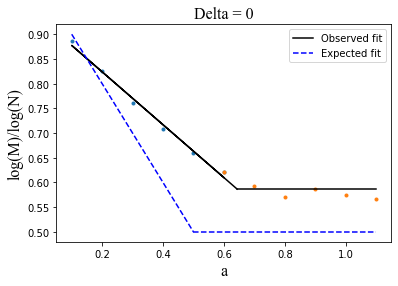

In [ ]:
#DELTA 0 PLOT

delayfirsthalf = np.array(delays[0:6])
delaysecondhalf = np.array(delays[5:11])


yvals = [math.log(i)/math.log(100000) for i in maxdegs[0]]
yvalsfirsthalf = yvals[0:6]
yvalssecondhalf = yvals[5:11]

a, b = np.polyfit(delayfirsthalf[0:6], yvalsfirsthalf[0:6], 1)

c = np.mean(yvalssecondhalf)

plt.figure()
plt.title('Delta = 0', fontname='Times New Roman', size=16)
plt.xlabel('a', fontname='Times New Roman', size=16)
plt.ylabel('log(M)/log(N)', fontname='Times New Roman', size=16)
plt.plot(delayfirsthalf, yvalsfirsthalf, '.')
plt.plot(delaysecondhalf, yvalssecondhalf, '.')
plt.plot(np.append([0.6435], delayfirsthalf), a* np.append([0.6435], delayfirsthalf) + b, 'k-', label = 'Observed fit')
plt.plot(np.append([0.6435], np.delete(delaysecondhalf,0)), [c]*6, 'k-')
plt.plot(delayfirsthalf[0:5], 1 - delayfirsthalf[0:5], 'b--', label = 'Expected fit')
plt.plot(np.append([0.5], delaysecondhalf), [0.5]*7, 'b--')
plt.legend(loc='upper right')
plt.show()



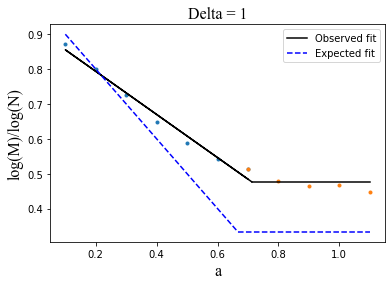

In [ ]:
#DELTA 1 PLOT

#delays = [math.log(i) for i in delays]
delayfh = np.array(delays[0:7])
delaysh = np.array(delays[6:11])


yvals = [math.log(i)/math.log(100000) for i in maxdegs[2]]
yvalsfh = yvals[0:7]
yvalssh = yvals[6:11]

a, b = np.polyfit(delayfh[0:7], yvalsfh[0:7], 1)

c = np.mean(yvalssh)


#x = np.linspace(0.1, 1.1, num = 11)
#xfunc = np.linspace(0.1, 1.1, num = 11)
#y = 1/30000 * (x)**-1 + 685
plt.figure()
plt.title('Delta = 1', fontname='Times New Roman', size=16)
plt.xlabel('a', fontname='Times New Roman', size=16)
plt.ylabel('log(M)/log(N)', fontname='Times New Roman', size=16)
plt.plot(delayfh, yvalsfh, '.')
plt.plot(delaysh, yvalssh, '.')
plt.plot(np.append([0.713], delayfh), a* np.append([0.713], delayfh) + b, 'k-', label = 'Observed fit')
plt.plot(np.append([0.7139], np.delete(delaysh,0)), [c]*5, 'k-')
plt.plot(np.append(delayfh[0:6], [0.667]), 1 - np.append(delayfh[0:6], [0.667]), 'b--', label = 'Expected fit')
plt.plot(np.append([0.667], delaysh), [0.333]*6, 'b--')
#plt.plot(xfunc, y, label = "-27003$(x - 1.1)^7$ + 685")
plt.legend(loc='upper right')
plt.show()

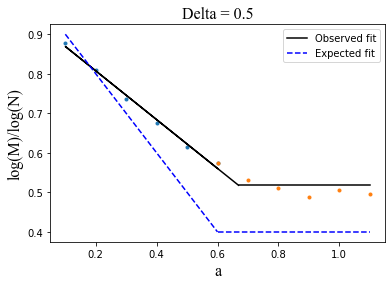

-0.6170550076363948
0.9307945698938879
0.51776292315624


In [ ]:
#DELTA 0.5 PLOT

#delays = [math.log(i) for i in delays]
delayfirsthalf = np.array(delays[0:6])
delaysecondhalf = np.array(delays[5:11])


yvals = [math.log(i)/math.log(100000) for i in maxdegs[1]]
yvalsfirsthalf = yvals[0:6]
yvalssecondhalf = yvals[5:11]

a, b = np.polyfit(delayfirsthalf[0:6], yvalsfirsthalf[0:6], 1)

c = np.mean(yvalssecondhalf)


#x = np.linspace(0.1, 1.1, num = 11)
#xfunc = np.linspace(0.1, 1.1, num = 11)
#y = 1/30000 * (x)**-1 + 685
plt.figure()
plt.title('Delta = 0.5', fontname='Times New Roman', size=16)
plt.xlabel('a', fontname='Times New Roman', size=16)
plt.ylabel('log(M)/log(N)', fontname='Times New Roman', size=16)
plt.plot(delayfirsthalf, yvalsfirsthalf, '.')
plt.plot(delaysecondhalf, yvalssecondhalf, '.')
plt.plot(np.append([0.669], delayfirsthalf), a* np.append([0.669], delayfirsthalf) + b, 'k-', label = 'Observed fit')
plt.plot(np.append([0.6699], np.delete(delaysecondhalf,0)), [c]*6, 'k-')
plt.plot(delayfirsthalf[0:6], 1 - delayfirsthalf[0:6], 'b--', label = 'Expected fit')
plt.plot(delaysecondhalf, [0.4]*6, 'b--')
plt.legend(loc='upper right')
plt.show()
print(a)
print(b) 
print(c)

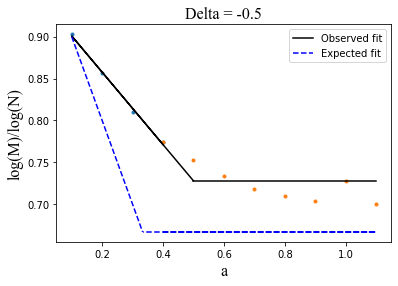

-0.4319815069287973
0.9439602596004364
0.7276899941078043


In [ ]:
#DELTA -0.5 PLOT

#delays = [math.log(i) for i in delays]
delayfirsthalf = np.array(delays[0:4])
delaysecondhalf = np.array(delays[3:11])


yvals = [math.log(i)/math.log(100000) for i in maxdegs[3]]
yvalsfirsthalf = yvals[0:4]
yvalssecondhalf = yvals[3:11]

a, b = np.polyfit(delayfirsthalf[0:4], yvalsfirsthalf[0:4], 1)

c = np.mean(yvalssecondhalf)


#x = np.linspace(0.1, 1.1, num = 11)
#xfunc = np.linspace(0.1, 1.1, num = 11)
#y = 1/30000 * (x)**-1 + 685
plt.figure()
plt.title('Delta = -0.5', fontname='Times New Roman', size=16)
plt.xlabel('a', fontname='Times New Roman', size=16)
plt.ylabel('log(M)/log(N)', fontname='Times New Roman', size=16)
plt.plot(delayfirsthalf, yvalsfirsthalf, '.')
plt.plot(delaysecondhalf, yvalssecondhalf, '.')
plt.plot(np.append([0.5], delayfirsthalf), a* np.append([0.5], delayfirsthalf) + b, 'k-', label = 'Observed fit')
plt.plot(np.append([0.5], np.delete(delaysecondhalf,0)), [c]*8, 'k-')
plt.plot(np.append(delayfirsthalf[0:3], [0.333]), 1 - np.append(delayfirsthalf[0:3], [0.333]), 'b--', label = 'Expected fit')
plt.plot(np.append(delaysecondhalf, [0.333]), [0.667]*9, 'b--')
plt.legend(loc='upper right')
plt.show()
print(a)
print(b) 
print(c)

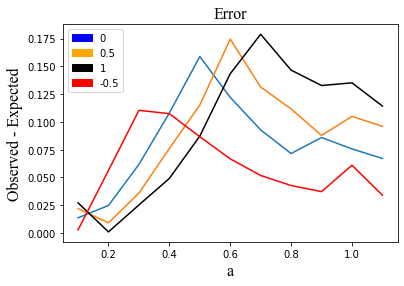

In [ ]:
import matplotlib.patches as mpatches

#DELTA 0

expected = [1 - i for i in delays if i <= 0.5]
expected += [0.5]*6

actual = [math.log(i)/math.log(100000) for i in maxdegs[0]]


differencebetween = abs(np.subtract(expected, actual))
plt.figure()
plt.title('Error', fontname='Times New Roman', size=16)
plt.xlabel('a', fontname='Times New Roman', size=16)
plt.ylabel('Observed - Expected', fontname='Times New Roman', size=16)
plt.plot(delays, differencebetween, '-')

#DELTA 0.5

expectednonzero = [1 - i for i in delays if i <= 0.6]
expectednonzero += [0.4]*5

actualnz = actual = [math.log(i)/math.log(100000) for i in maxdegs[1]]

diffbetnz = abs(np.subtract(expectednonzero, actualnz))

plt.plot(delays, diffbetnz, '-')

#DELTA 1

expectedone = [1 - i for i in delays if i <= 0.6]
expectedone += [0.3333]*5

actualone = [math.log(i)/math.log(100000) for i in maxdegs[2]]

diffbetone = abs(np.subtract(expectedone, actualone))

plt.plot(delays, diffbetone, '-', color='black')

#DELTA -0.5
 
expectedneg = [1 - i for i in delays if i <= 0.3]
expectedneg += [0.6667]*8

actualneg = [math.log(i)/math.log(100000) for i in maxdegs[3]]

diffbetneg = abs(np.subtract(expectedneg, actualneg))

plt.plot(delays, diffbetneg, '-', color='red')


#Legend
blue_patch = mpatches.Patch(color='blue', label='0')
orange_patch = mpatches.Patch(color='orange', label='0.5')
black_patch = mpatches.Patch(color='black', label = '1')
red_patch = mpatches.Patch(color='red', label = '-0.5')


plt.legend(handles = [blue_patch, orange_patch, black_patch, red_patch])